In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
train_sample = pd.read_csv("train_sample.csv",parse_dates=[5])

In [149]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [150]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null datetime64[ns]
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 6.1+ MB


In [151]:
train_sample.channel.value_counts().index

Int64Index([280, 245, 107, 477, 134, 259, 265, 153, 178, 121,
            ...
            410, 455,  15, 114,   4, 261, 498, 465, 474, 451],
           dtype='int64', length=161)

In [152]:
train_sample[train_sample.duplicated()]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
84125,871,12,1,13,178,2017-11-08 10:00:05,NaN,0


In [153]:
train_sample.dtypes

ip                          int64
app                         int64
device                      int64
os                          int64
channel                     int64
click_time         datetime64[ns]
attributed_time            object
is_attributed               int64
dtype: object

In [154]:
# Converting all integer columns to categorical 
train_sample[train_sample.columns[train_sample.dtypes!='datetime64[ns]']] = \
train_sample[train_sample.columns[train_sample.dtypes!='datetime64[ns]']].apply(lambda x:x.astype('category'))

In [155]:
train_sample.dtypes

ip                       category
app                      category
device                   category
os                       category
channel                  category
click_time         datetime64[ns]
attributed_time          category
is_attributed            category
dtype: object

In [156]:
# describe dataset

train_sample.describe(include=['category'])

,ip,app,device,os,channel,attributed_time,is_attributed
count,100000,100000,100000,100000,100000,227,100000
unique,34857,161,100,130,161,227,2
top,5348,3,1,19,280,2017-11-09 15:28:15,0
freq,669,18279,94338,23870,8114,1,99773


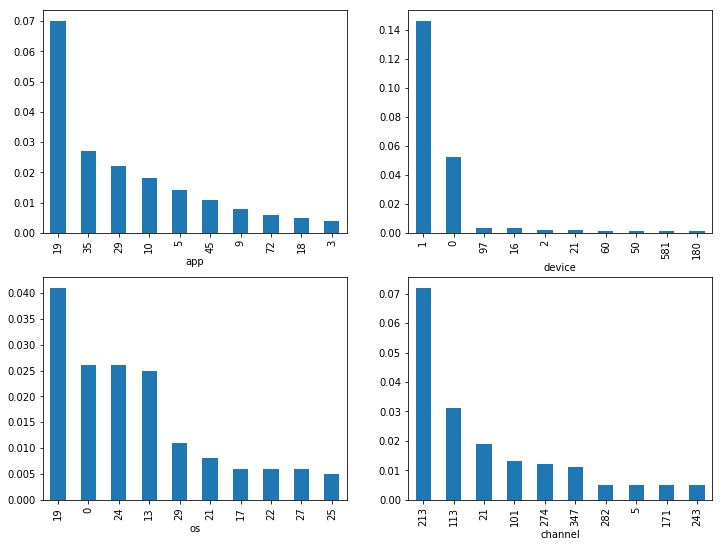

In [157]:
train_sample['is_attributed'] = train_sample.is_attributed.astype('int64')

# Calculating event rates for top 10 categories

fig,axes = plt.subplots(2,2, figsize = (12,9))

(train_sample.groupby(['app']).is_attributed.sum().sort_values(ascending = False)*100/train_sample.shape[0])[:10].plot(kind = 'bar',ax = axes[0,0])

(train_sample.groupby(['device']).is_attributed.sum().sort_values(ascending = False)*100/train_sample.shape[0])[:10].plot(kind = 'bar',ax = axes[0,1])
(train_sample.groupby(['os']).is_attributed.sum().sort_values(ascending = False)*100/train_sample.shape[0])[:10].plot(kind = 'bar',ax = axes[1,0])
(train_sample.groupby(['channel']).is_attributed.sum().sort_values(ascending = False)*100/train_sample.shape[0])[:10].plot(kind = 'bar',ax = axes[1,1])
plt.show()

Variation in event rate for apps, devices, os and channels can be observed. We are only looking at categories with top 10 event rate.


In [158]:
# Creating time based features

import datetime as dt

train_sample['hour_of_day'] = train_sample.click_time.dt.hour
train_sample['dow'] = train_sample.click_time.dt.day


In [159]:
# Creating number of clicks by ip

df_test = pd.concat([train_sample.groupby(['ip']).app.count(),\
          train_sample.groupby(['ip']).is_attributed.sum()],axis = 1)

# df_test[(df_test.app==1) & (df_test.is_attributed==1)].sort_values(['app'],ascending = False)

In [160]:
import datetime as dt

In [161]:
# Calculating time from previous click
train_sample.sort_values(['ip','click_time'],inplace=True)
train_sample['lag_click_time'] = train_sample.groupby(['ip']).click_time.shift(1)
train_sample['lag_time_btw_clicks_by_ip'] = train_sample.click_time - train_sample.lag_click_time
train_sample['lag_time_btw_clicks_by_ip'].fillna(0,inplace = True)
train_sample['lag_time_btw_clicks_by_ip'] = train_sample['lag_time_btw_clicks_by_ip'].dt.total_seconds()
train_sample.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour_of_day,dow,lag_click_time,lag_time_btw_clicks_by_ip
4249,9,9,1,13,244,2017-11-07 16:06:42,NaN,0,16,7,NaT,0.0
18992,10,11,1,22,319,2017-11-07 01:37:19,NaN,0,1,7,NaT,0.0
25399,10,12,1,19,140,2017-11-07 07:33:04,NaN,0,7,7,2017-11-07 01:37:19,21345.0
51193,10,18,1,13,107,2017-11-08 11:19:15,NaN,0,11,8,2017-11-07 07:33:04,99971.0
10686,19,14,1,16,379,2017-11-08 09:12:26,NaN,0,9,8,NaT,0.0


In [162]:
# calculating running average of inter-click time

train_sample['cum_inter_click_time_by_ip'] = train_sample.groupby(['ip']).lag_time_btw_clicks_by_ip.cumsum()
train_sample['obs_num'] = 1
train_sample['obs_num'] = train_sample.groupby('ip')['obs_num'].cumsum()

In [163]:
train_sample['obs_num'] = train_sample['obs_num'] - 1
train_sample['avg_inter_click_time_by_ip'] = train_sample['cum_inter_click_time_by_ip']/train_sample['obs_num']

In [164]:
train_sample['avg_inter_click_time_by_ip'] = train_sample.avg_inter_click_time_by_ip.fillna(0)

In [165]:
# Creating indicator feature for first click by IP

def first_click(num):
    if num==0:
        return 1
    else:
        return 0
    
train_sample['first_click_by_ip_flag'] = train_sample.obs_num.apply(lambda x: first_click(x))

In [166]:
features = ['app', 'device', 'os', 'channel', 'lag_time_btw_clicks_by_ip',
            'obs_num', 'avg_inter_click_time_by_ip','first_click_by_ip_flag', 'hour_of_day','dow']

cat_features = ['app','device','os','channel','first_click_by_ip_flag', 'hour_of_day', 'dow']
num_features = ['lag_click_time','lag_time_btw_clicks_by_ip','obs_num','avg_inter_click_time_by_ip']

### Analyzing each variable

In [167]:
def get_summary(data,cat_var):
    print("Total number of unique categories: ",data[cat_var].nunique())
    
    ## Number of applications with 0 installations and getting their distributions
    install_count = data.groupby([cat_var]).is_attributed.sum()
    print("Number of applications with installation clicks: ",
      np.where(install_count>0)[0].shape[0])
    print("List of Applications: ",np.where(install_count>0)[0])
    
    ## Distribution of installations by apps
    install_count.plot(kind = 'hist',bins =40, figsize = (10,7))
    plt.title("distribution of Installations by "+cat_var)
    plt.show()
    
    ## Outlier value 
    max_cat = install_count[install_count ==install_count.max()]
    print(cat_var,max_cat.index.values[0]," has installations of ",max_cat.values[0])
    
    ## Num of clicks and distribution
    
    click = data.groupby([cat_var]).ip.count()
    click.plot(kind = 'hist',bins =40, figsize = (10,7))
    plt.title("distribution of Clicks by "+cat_var)

    plt.show()

Total number of unique categories:  161
Number of applications with installation clicks:  37
List of Applications:  [  2   4   7   8   9  10  11  14  17  18  19  28  31  33  34  38  42  45
  47  53  55  57  64  65  74  75  85  90  93  94  98  99 107 112 131 133
 138]


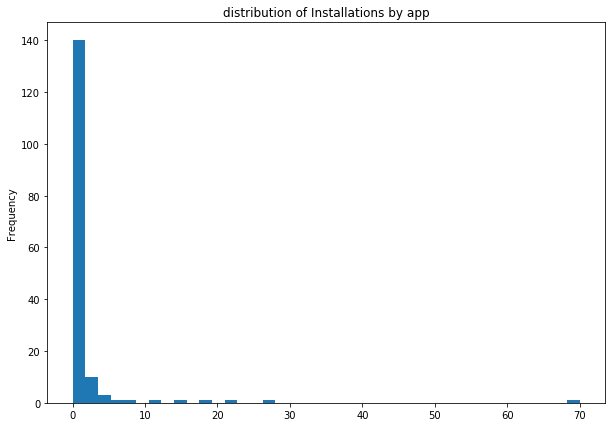

app 19  has installations of  70


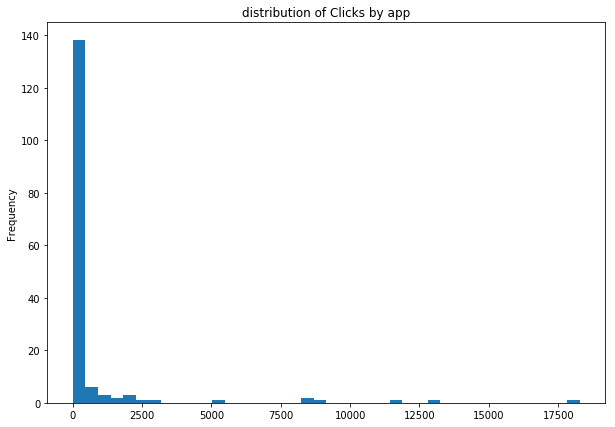

In [168]:
get_summary(train_sample,cat_var='app')

Total number of unique categories:  100
Number of applications with installation clicks:  25
List of Applications:  [ 0  1  2  3  5  9 13 15 16 17 19 21 23 26 28 32 34 37 39 46 48 61 73 74 81]


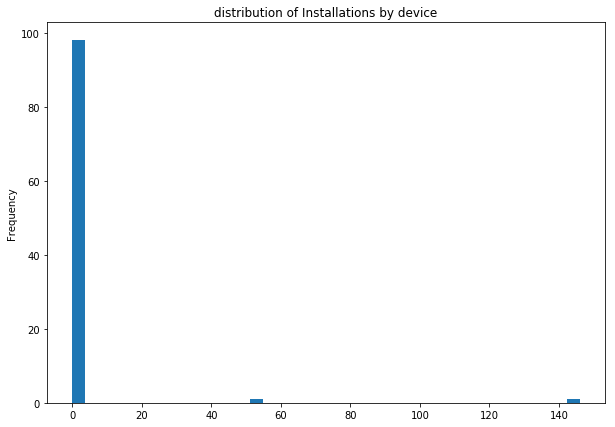

device 1  has installations of  146


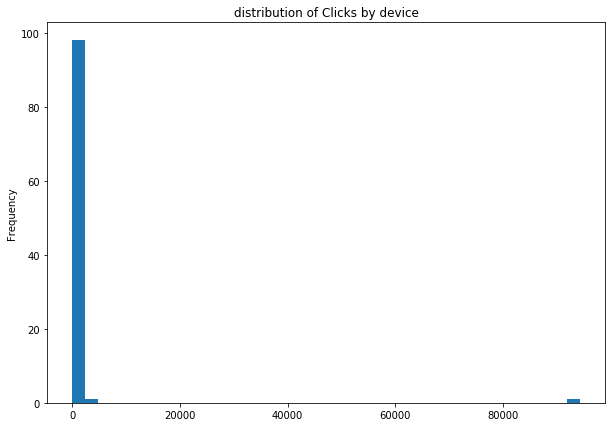

In [169]:
get_summary(train_sample,cat_var='device')

Total number of unique categories:  130
Number of applications with installation clicks:  39
List of Applications:  [  0   1   2   3   4   6   7   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  32  34  35  36  37  42  46  56
  58 127 129]


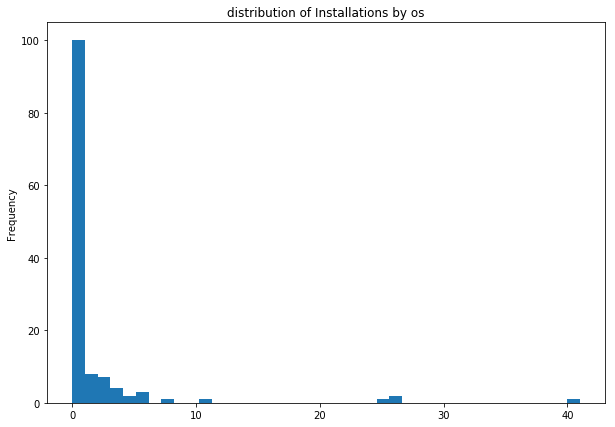

os 19  has installations of  41


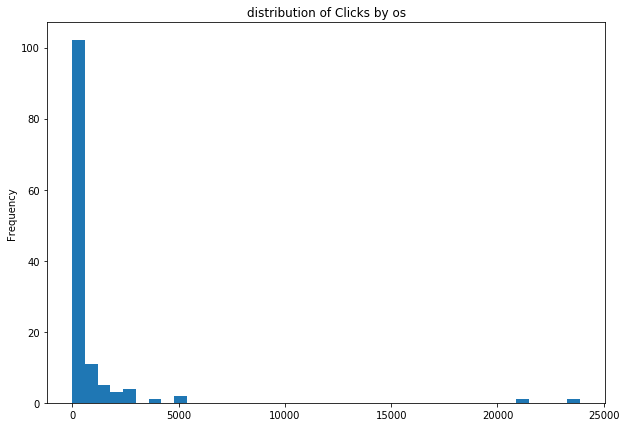

In [170]:
get_summary(train_sample,'os')

Total number of unique categories:  161
Number of applications with installation clicks:  40
List of Applications:  [  0   2   8  12  14  18  19  23  24  32  33  38  42  43  47  53  62  70
  72  74  77  78  82  89  92  93  94 104 105 119 121 125 126 127 130 141
 142 147 154 156]


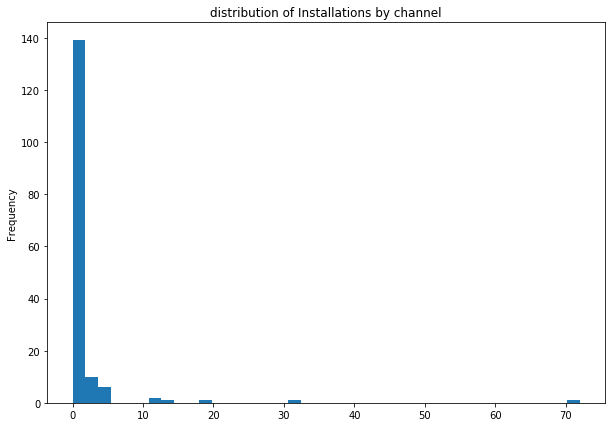

channel 213  has installations of  72


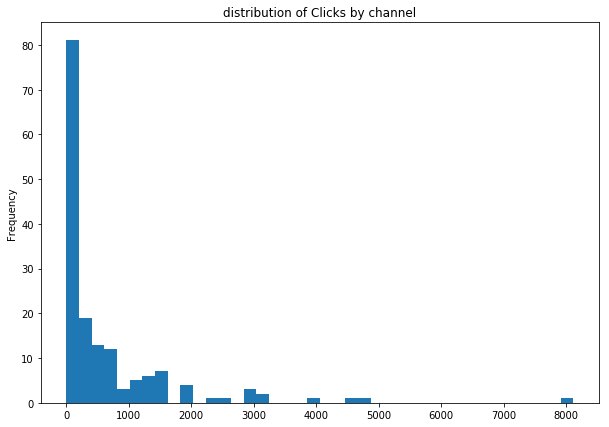

In [171]:
get_summary(train_sample,'channel')

In [172]:
# Creating Count-based features for high cardinality features
# Example:  Count number of IPs used by each device

train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour_of_day,dow,lag_click_time,lag_time_btw_clicks_by_ip,cum_inter_click_time_by_ip,obs_num,avg_inter_click_time_by_ip,first_click_by_ip_flag
4249,9,9,1,13,244,2017-11-07 16:06:42,NaN,0,16,7,NaT,0.0,0.0,0,0.0,1
18992,10,11,1,22,319,2017-11-07 01:37:19,NaN,0,1,7,NaT,0.0,0.0,0,0.0,1
25399,10,12,1,19,140,2017-11-07 07:33:04,NaN,0,7,7,2017-11-07 01:37:19,21345.0,21345.0,1,21345.0,0
51193,10,18,1,13,107,2017-11-08 11:19:15,NaN,0,11,8,2017-11-07 07:33:04,99971.0,121316.0,2,60658.0,0
10686,19,14,1,16,379,2017-11-08 09:12:26,NaN,0,9,8,NaT,0.0,0.0,0,0.0,1


In [173]:
X = train_sample[features].copy()
y = train_sample.is_attributed.copy()


In [174]:
X.dtypes

app                           category
device                        category
os                            category
channel                       category
lag_time_btw_clicks_by_ip      float64
obs_num                          int64
avg_inter_click_time_by_ip     float64
first_click_by_ip_flag           int64
hour_of_day                      int64
dow                              int64
dtype: object

In [175]:
X['first_click_by_ip_flag'] = X.first_click_by_ip_flag.astype('category')
X['hour_of_day'] = X.hour_of_day.astype('category')
X['dow'] = X.dow.astype('category')

In [116]:
X = pd.get_dummies(X)

In [117]:
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.25,shuffle = True,random_state = 42)

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest,f_classif


logreg_pipe = make_pipeline(SelectKBest(k=100,score_func = f_classif),StandardScaler(),LogisticRegression())
cross_val_score(logreg_pipe,X_train,y_train,scoring = 'roc_auc')

/home/vinayak/miniconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 32  49  67  83  84  91  97 100 102 107 109 111 113 114 115 118 121 123
 124 128 132 135 138 141 148 153 154 156 157 158 159 160 161 162 167 180
 182 185 186 191 193 195 197 200 205 211 214 215 216 218 219 221 222 225
 227 229 230 234 235 238 239 241 242 245 246 247 248 255 263 354 355 356
 363 364 366 370 371 375 376 379 380 383 384 388 395 462 508 529 554] are constant.
  UserWarning)
/home/vinayak/miniconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/vinayak/miniconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 36  66  74  84  88  91 101 102 106 114 115 118 121 132 133 135 144 145
 147 148 155 156 162 163 171 172 17

array([ 0.92841416,  0.93507254,  0.91775783])

### Possible features

* count number of clicks by ip 
* clicks within time interval of an IP. Example: > 10 clicks within 5 mins of an IP --> category
* clicks within time interval of an IP. Example: > 10 clicks within 5 mins of an IP --> category
* Based on distribution of number of clicks taken to install for an IP create flag
